<body>Import necessary packages </body>



In [25]:
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import requests

<body> Get data from the website and store it in a dataframe. Remove the data with does not match the required format</body>

In [37]:

columns=list(['PostalCode', 'Borough', 'Neighborhood'])
df= pd.DataFrame(columns=columns)
url ="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
result = requests.get(url).text
soup = BeautifulSoup(result, 'html.parser')
table=soup.table.tbody
valid_bor=list()
for sibling in table.children:
    if (type(sibling)!= bs4.element.NavigableString):
        l=[]
        for i in sibling.find_all('td'):
            l.append(i.text)
            
        if len(l)==3 and str(l[1])!='Not assigned':
            if l[2][0:-1] =='Not assigned':
                l[2]=l[1]+'-'
            valid_bor.append(pd.Series([l[0],l[1],l[2][0:-1]], index=df.columns))
               
df=df.append(valid_bor,ignore_index=True)
df1=df

<body> Groupby Postal code and group the Neighbourhoods <body>

In [28]:
df=df.groupby('PostalCode')
df_group=pd.DataFrame(columns=columns)
lis=[]
for i in df:
     lis.append(pd.Series([i[0],i[1]['Borough'].values[0],', '.join(list(i[1]['Neighborhood']))], index=columns))
    
df_group=df_group.append(lis,ignore_index=True)

<body>Print size</body>


In [30]:
df_group.shape[0]

103

<body> Adding geo data </body>

In [32]:
geo=pd.read_csv('geo.csv')
final=pd.merge(df_group, geo, left_on='PostalCode', right_on='Postal Code')
final.drop("Postal Code",axis=1)
final

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,M1J,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",M1K,43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",M1L,43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",M1M,43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",M1N,43.692657,-79.264848


<body>Using kmeans to cluster and plot all the areas based on location </body>

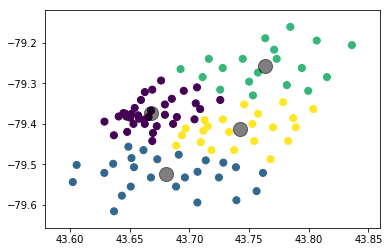

In [34]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=4)
data=final[['Latitude','Longitude']].values
x=kmeans.fit(data)
y_kmeans = kmeans.predict(data)
final['label']=x.labels_
plt.scatter(final['Latitude'], final['Longitude'], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


<body> Get all toronto related data </body>

In [38]:
df1['Borough']=df1['Borough'].astype(str)
df1=pd.merge(df1, geo, left_on='PostalCode', right_on='Postal Code')
toronto=df1[df1['Borough'].str.contains('Toronto')]


<body> Plot on map </body>

In [40]:
# create map of Manhattan using latitude and longitude values
import folium
toronto_map = folium.Map(location=[43.676357, -79.321558], zoom_start=11)
#print(toronto)
# add markers to map
for lat, lng, label in zip(toronto['Latitude'],toronto['Longitude'], toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

<body>List of all venues in Toronto</body> 

In [45]:
CLIENT_ID = 'Y0AYK5I321AA5FHVBRU0SMERMNKPCJAHCIMANXUQW3T1CXHR' # your Foursquare ID
CLIENT_SECRET = 'EFBBYD4HMCA3AAL3KN2FW04FT5LGXS3TFNYY2PMX2IXHKIBJ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    #print(venues_list)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

places_in_toronto= getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )
places_in_toronto.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
